In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from pyDOE import lhs

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

import scipy
import scipy.io
from sklearn.feature_selection import mutual_info_regression

import time
from tqdm import tqdm

sns.set_style("white")


# Schrödinger equation is a linear partial differential equation that 
# governs the wave function of a quantum-mechanical system.
# It is used to predicts the future behavior of a dynamic system.

c:\Users\omi222\Anaconda3\envs\project_lehigh\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N_train = 5000

layers = [3, 20, 2, 8]

# Load Data
data = scipy.io.loadmat('data/cylinder_nektar_wake.mat')
        
U_star = torch.tensor(data['U_star']).float() # N x 2 x T
P_star = torch.tensor(data['p_star']).float() # N x T
t_star = torch.tensor(data['t']).float() # T x 1
X_star = torch.tensor(data['X_star']).float() # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = torch.tile(X_star[:,0:1], (1,T)) # N x T
YY = torch.tile(X_star[:,1:2], (1,T)) # N x T
TT = torch.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
idx = np.random.choice(N*T, N_train, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]

snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]



In [21]:
# Create MLP for model training



class PINN(nn.Module):
    def __init__(self, input_size, hidden_size,
                 output_size, n_layers) -> None:
        super(PINN, self).__init__()

        layers = [("input", torch.nn.Linear(input_size, hidden_size))]
        layers.append(("input_activation", torch.nn.Tanh()))

        # For every other layer
        for i in range(n_layers):
            layers = layers + [
                (f"hidden_{i}", torch.nn.Linear(hidden_size, hidden_size)),
                # (f"drop_{i}", torch.nn.Dropout(0.1)),
                (f"activation{i}", torch.nn.Tanh()),
            ]

        layers.append(("output", torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        ##print(type(x))
        out = self.layers(x)
        return out


class ModelNetwork():
    def __init__(self, x, y, t, u, v, layers):
        
        ########################################
        # Initialize model Inputs and parameters
        
        X = torch.concat((x, y, t), 1)
        self.X = X
        
        # Periodic Boundary Conditions
        self.lb = X.amin(0)
        self.ub = X.amax(0)
        
        self.x = X[:, 0:1].requires_grad_()
        self.y = X[:, 1:2].requires_grad_()
        self.t = X[:, 2:3].requires_grad_()
        
        self.u = u
        self.v = v
        
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).float()
        self.lambda_2 = torch.tensor([0.0], requires_grad=True).float()
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        self.pinn = PINN(*layers)
        self.pinn.register_parameter("lambda1", self.lambda_1)
        self.pinn.register_parameter("lambda2", self.lambda_2)
        
        self.optimizer = torch.optim.LBFGS(
            self.pinn.parameters(),
            lr = 1.0, 
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_change=1.0 * np.finfo(float).eps
        )
        self.optimizer_Adam = torch.optim.Adam(self.pinn.parameters())
        self.iter = 0
        
    def net_NS(self, x, y, t):
        
        lambda1 = self.lambda_1
        lambda2 = self.lambda_2
        
        X = torch.concat([x, y, t], 1)
        X = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        psi_and_p = self.pinn(X)
        
        psi = psi_and_p[:, 0:1]
        p = psi_and_p[:, 1:2]
        
        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi)
                                  , retain_graph = True, create_graph = True)[0]
        v = -torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi)
                                  , retain_graph = True, create_graph = True)[0]
        
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u)
                                  , retain_graph = True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u)
                                  , retain_graph = True, create_graph = True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u)
                                  , retain_graph = True, create_graph = True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x)
                                  , retain_graph = True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y)
                                  , retain_graph = True)[0]
        
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v)
                                  , retain_graph = True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v)
                                  , retain_graph = True, create_graph = True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v)
                                  , retain_graph = True, create_graph = True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x)
                                  , retain_graph = True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y)
                                  , retain_graph = True)[0]
        
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p)
                                  , retain_graph = True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p)
                                  , retain_graph = True)[0]
        
        f_u = u_t + lambda1*(u * u_x + v*u_y) + p_x - lambda2*(u_xx + u_yy)
        f_v = v_t + lambda1*(v * v_x + v*v_y) + p_y - lambda2*(v_xx + v_yy)
        
        
        return u, v, p, f_u, f_v

        
    def loss_func(self):
        self.u_pred, self.v_pred, self.p_pred ,self.f_u_pred, self.f_v_pred = self.net_NS(self.x,self.y,self.t)    
        
        
        self.loss = ((torch.sum(torch.square(self.u - self.u_pred)) +
                      torch.sum(torch.square(self.v - self.v_pred))) + 
                     (torch.sum(torch.square(self.f_u_pred)) + 
                      torch.sum(torch.square(self.f_v_pred)))
                     )
        self.optimizer.zero_grad()
        self.loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                "Iter: %d, Loss: %.5f, L1: %.3f, L2: %.5f, Time: %.2f" %
                (
                    self.iter,  self.loss.item(), 
                    self.lambda_1.item(), self.lambda_2.item(), time.time() - self.start
            ))
            self.start = time.time()
        return self.loss
    
    def train(self, epochs):
        self.start = time.time()
        for epoch in range(epochs):
            self.optimizer_Adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
    


In [26]:
seed = 27
import random
#torch.random.seed(seed)
# Add dropout
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

model = ModelNetwork(x_train, y_train, t_train, u_train, v_train, layers)
model.train(20000)

Iter: 100, Loss: 1415.05200, L1: 0.071, L2: -0.00079, Time: 13.60
Iter: 200, Loss: 1017.34058, L1: 0.080, L2: 0.00738, Time: 11.15
Iter: 300, Loss: 1019.26447, L1: 0.028, L2: 0.00672, Time: 10.91
Iter: 400, Loss: 1026.46619, L1: 0.009, L2: 0.00653, Time: 11.71
Iter: 500, Loss: 1027.53613, L1: 0.069, L2: 0.00840, Time: 11.87
Iter: 600, Loss: 1010.67554, L1: 0.076, L2: 0.00837, Time: 11.93
Iter: 700, Loss: 987.88416, L1: 0.039, L2: 0.00683, Time: 11.74
Iter: 800, Loss: 956.27673, L1: -0.008, L2: 0.00480, Time: 11.95
Iter: 900, Loss: 910.56934, L1: -0.053, L2: 0.00256, Time: 11.30
Iter: 1000, Loss: 912.04858, L1: -0.076, L2: 0.00070, Time: 11.02
Iter: 1100, Loss: 893.22253, L1: -0.087, L2: 0.00010, Time: 11.27
Iter: 1200, Loss: 881.71460, L1: -0.088, L2: -0.00002, Time: 11.23
Iter: 1300, Loss: 877.29187, L1: -0.093, L2: -0.00023, Time: 10.96
Iter: 1400, Loss: 860.12476, L1: -0.099, L2: -0.00051, Time: 11.19
Iter: 1500, Loss: 850.48645, L1: -0.106, L2: -0.00088, Time: 11.87
Iter: 1600, Los

In [27]:
model.lambda_1 

Parameter containing:
tensor([nan], requires_grad=True)

In [24]:
x_star = x_star.requires_grad_()
y_star = y_star.requires_grad_()
t_star = t_star.requires_grad_()
    

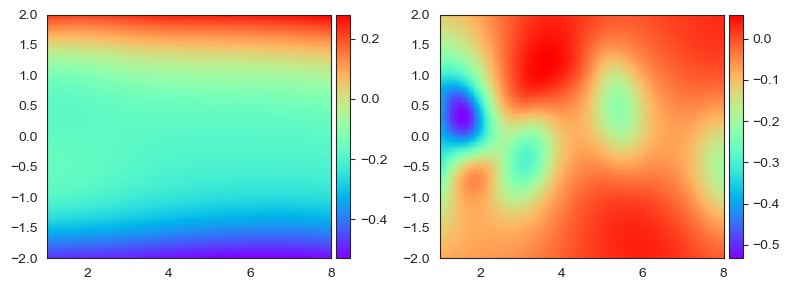

In [25]:
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

model.pinn.eval()
u_pred, v_pred, p_pred, _, _ = model.net_NS(x_star, y_star, t_star)

#h_pred = np.sqrt(u_pred**2 + v_pred**2)

#H_pred = griddata(X_star, h_pred.flatten(), (X, T), method = 'cubic')

# Predict for plotting
lb = X_star.amin(0)
ub = X_star.amax(0)
pn = 200
x = np.linspace(lb[0], ub[0], pn)
y = np.linspace(lb[1], ub[1], pn)
X, Y = np.meshgrid(x,y)
PP_star = griddata(X_star, p_pred.flatten().detach().numpy(), (X, Y), method='cubic')
P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')

fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(121)

h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.detach().numpy().min(), x_star.detach().numpy().max(), y_star.detach().numpy().min(), y_star.detach().numpy().max()], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)


ax1 = fig.add_subplot(122)

h = ax1.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.detach().numpy().min(), x_star.detach().numpy().max(), y_star.detach().numpy().min(), y_star.detach().numpy().max()], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)

plt.tight_layout()

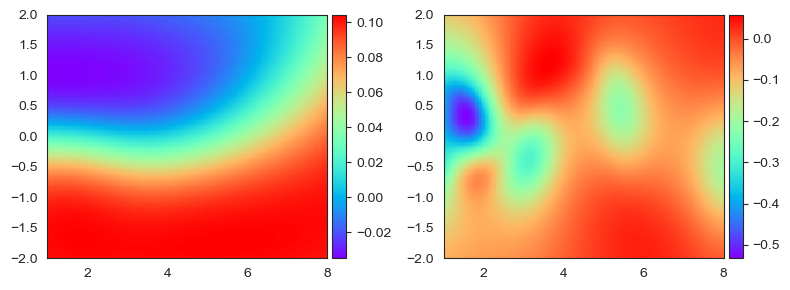

In [8]:
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

model.pinn.eval()
u_pred, v_pred, p_pred, _, _ = model.net_NS(x_star, y_star, t_star)

#h_pred = np.sqrt(u_pred**2 + v_pred**2)

#H_pred = griddata(X_star, h_pred.flatten(), (X, T), method = 'cubic')

# Predict for plotting
lb = X_star.amin(0)
ub = X_star.amax(0)
nn = 200
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)
PP_star = griddata(X_star, p_pred.flatten().detach().numpy(), (X, Y), method='cubic')
P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')

fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(121)

h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.detach().numpy().min(), x_star.detach().numpy().max(), y_star.detach().numpy().min(), y_star.detach().numpy().max()], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)


ax1 = fig.add_subplot(122)

h = ax1.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.detach().numpy().min(), x_star.detach().numpy().max(), y_star.detach().numpy().min(), y_star.detach().numpy().max()], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)

plt.tight_layout()

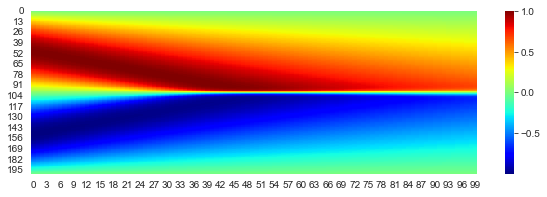

In [10]:
# Evaluating model

h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# Exact solution = 
X = torch.stack(torch.meshgrid(x, t, indexing = 'ij')).reshape(2, -1).T
plt.figure(figsize = (10, 3))
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).numpy()
    
sns.heatmap(y_pred, cmap = "jet")
plt.savefig("heatmap.png")
        
        

In [ ]:

new_format = []
presentdemand = []
window = 25

for idx, row in enumerate(df.values[window:-2]): # Starts from 12 hours from data start to predict demand at 12th hour
  weatherfeat = row[1:-1]
  pastdemand =  df['Total_Demand'][idx : idx + window]
  new_format.append(np.concatenate([weatherfeat, pastdemand]).astype(np.float32))
  presentdemand.append(row[-1])